# Multivariate Multiheaded 1D CNN Example

Based on:
* [Time Series Forecasting on Stock Prices](https://www.youtube.com/watch?v=j05UUs99eNQ) from [Coding Tech](https://www.youtube.com/channel/UCtxCXg-UvSnTKPOzLH4wJaQ)
* https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/

**Disclaimer:** _Investing in the stock market involves risk and can lead to monetary loss. This material is purely for educational purposes and should not be taken as professional investment advice. Invest at your own discretion._

Import the libraries

In [1]:
import pandas as pd
import numpy as np

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, concatenate

import matplotlib.pyplot as plt

Load the data

In [2]:
df = pd.read_csv("SP500.csv")

Show the data

In [3]:
df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2000-05-19,96.106028,96.106028,94.484962,94.779701,775500,0.0,0
1,2000-05-22,94.716551,94.716551,92.169162,94.190231,1850600,0.0,0
2,2000-05-23,94.463952,94.463952,92.758675,92.758675,373900,0.0,0
3,2000-05-24,92.800753,94.358660,92.063905,94.148132,400300,0.0,0
4,2000-05-25,94.337613,94.948145,92.884970,93.284973,69600,0.0,0
...,...,...,...,...,...,...,...,...
5359,2021-09-08,452.899994,453.679993,450.869995,453.000000,4076800,0.0,0
5360,2021-09-09,452.690002,454.579987,450.730011,450.980011,3851600,0.0,0
5361,2021-09-10,453.059998,453.510010,447.299988,447.540009,3023500,0.0,0
5362,2021-09-13,450.679993,450.929993,446.089996,448.579987,3007400,0.0,0


Add indices for every day in the period

In [4]:
start_date = df.Date.min()
end_date = df.Date.max()

In [5]:
df_date = pd.date_range(start=start_date, end=end_date).to_frame(name="Date")
df_date.reset_index(drop=True, inplace=True) 

In [6]:
df["Date"] = pd.to_datetime(df["Date"])
df = df.merge(df_date, how='right')

Interpolate missing values

In [7]:
df = df.interpolate(method='linear', limit_direction='both')

Remove not needed columns

In [8]:
df = df[['Date', 'Close']].copy()

In [9]:
df

,Date,Close
0,2000-05-19,94.779701
1,2000-05-20,94.583211
2,2000-05-21,94.386721
3,2000-05-22,94.190231
4,2000-05-23,92.758675
...,...,...
7784,2021-09-10,447.540009
7785,2021-09-11,447.886668
7786,2021-09-12,448.233327
7787,2021-09-13,448.579987


**Simple Moving Average**
* Example periods: 15, 30 or 45 days

In [10]:
def computeSMA(data, period, column='Close'):
    return data[column].rolling(window=period).mean()

In [11]:
df['SMA'] = computeSMA(df, period=15)

**Exponential Moving Averages**
* Example periods: 15, 30 or 45 days

In [12]:
def computeEMA(data, period, column='Close'):
    return data[column].ewm(span=period, adjust=False).mean()

In [13]:
df['EMA'] = computeEMA(df, period=15)

**Relative Strength Index**

In [14]:
def computeRSI(data, period=14, column='Close'):
    delta = data[column].diff(1)
    delta = delta.dropna()
    up = delta.copy()
    down = delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    data['up'] = up
    data['down'] = down
    AVG_Gain = computeSMA(data, period, column='up')
    AVG_Loss = abs(computeSMA(data, period, column='down'))
    RS = AVG_Gain / AVG_Loss
    RSI = 100.0 - (100.0 / (1.0 + RS))
    return RSI

In [15]:
df['RSI'] = computeRSI(df, period=14)

**Moving Average Convergence Divergence**

In [16]:
def MACD(data, period1=26, period2=12, signal=9, column='Close'):
    exp1 = computeEMA(data,period1, column=column)
    exp2 = computeEMA(data,period2, column=column)
    data['MACD'] = exp2 - exp1
    data['Signal Line'] = computeSMA(data, signal, column='MACD')

In [17]:
MACD(df)

Remove NaNs

In [18]:
df = df.dropna()

In [19]:
df

,Date,Close,SMA,EMA,up,down,RSI,MACD,Signal Line
14,2000-06-02,99.663971,94.910938,95.600925,1.936874,0.000000,71.245582,0.680463,-0.042866
15,2000-06-03,99.446431,95.222053,96.081613,0.000000,-0.217539,71.115354,0.916439,0.090681
16,2000-06-04,99.228892,95.531765,96.475023,0.000000,-0.217539,70.985601,1.073524,0.250695
17,2000-06-05,99.011353,95.840074,96.792064,0.000000,-0.217539,70.856321,1.167008,0.420929
18,2000-06-06,98.506065,96.127796,97.006314,0.000000,-0.505287,77.029581,1.186644,0.585988
...,...,...,...,...,...,...,...,...,...
7784,2021-09-10,447.540009,453.257671,451.878931,0.000000,-3.440002,30.279938,1.487905,2.619024
7785,2021-09-11,447.886668,452.970782,451.379898,0.346659,0.000000,28.313930,1.046934,2.394046
7786,2021-09-12,448.233327,452.662337,450.986577,0.346659,0.000000,26.233827,0.717167,2.129901
7787,2021-09-13,448.579987,452.332335,450.685753,0.346659,0.000000,24.029401,0.478284,1.844411


Separate a multivariate sequence into samples

In [20]:
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # Find the end of the pattern
        end_ix = i + n_steps
        # Check if we are bound by sequence
        if end_ix > len(sequences) - 1:
            break
        # Gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

Define input sequence

In [21]:
in_seq1 = df['SMA'].values
in_seq2 = df['EMA'].values
in_seq3 = df['RSI'].values
in_seq4 = df['MACD'].values
in_seq5 = df['Signal Line'].values
out_seq = df['Close'].values

Convert to [rows, columns] structure

In [22]:
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
in_seq3 = in_seq3.reshape((len(in_seq3), 1))
in_seq4 = in_seq4.reshape((len(in_seq4), 1))
in_seq5 = in_seq5.reshape((len(in_seq5), 1))
out_seq = out_seq.reshape((len(out_seq), 1))

Horizontally stack columns

In [23]:
dataset = np.hstack((in_seq1, in_seq2, in_seq3, in_seq4, in_seq5, out_seq))

Choose a number of time steps

In [24]:
n_steps = 10

Convert into input/output

In [25]:
X, y = split_sequences(dataset, n_steps)

One time series per head

In [26]:
n_features = 1

Separate input data

In [27]:
X1 = X[:, :, 0].reshape(X.shape[0], X.shape[1], n_features)
X2 = X[:, :, 1].reshape(X.shape[0], X.shape[1], n_features)
X3 = X[:, :, 2].reshape(X.shape[0], X.shape[1], n_features)
X4 = X[:, :, 3].reshape(X.shape[0], X.shape[1], n_features)
X5 = X[:, :, 4].reshape(X.shape[0], X.shape[1], n_features)

Set test data

In [28]:
test_size = n_steps
prediction_size = n_features
y_test = y[-test_size-prediction_size:-prediction_size]
X1_test = X1[-test_size-prediction_size:-prediction_size]
X2_test = X2[-test_size-prediction_size:-prediction_size]
X3_test = X3[-test_size-prediction_size:-prediction_size]
X4_test = X4[-test_size-prediction_size:-prediction_size]
X5_test = X5[-test_size-prediction_size:-prediction_size]

In [29]:
y_expected = y[-prediction_size:]

In [30]:
y = y[:-test_size-prediction_size]
X1 = X1[:-test_size-prediction_size]
X2 = X2[:-test_size-prediction_size]
X3 = X3[:-test_size-prediction_size]
X4 = X4[:-test_size-prediction_size]
X5 = X5[:-test_size-prediction_size]

Define models

In [31]:
visible1 = Input(shape=(n_steps, n_features))
cnn1 = Conv1D(filters=64, kernel_size=2, activation='relu')(visible1)
cnn1 = MaxPooling1D(pool_size=2)(cnn1)
cnn1 = Flatten()(cnn1)

In [32]:
visible2 = Input(shape=(n_steps, n_features))
cnn2 = Conv1D(filters=64, kernel_size=2, activation='relu')(visible2)
cnn2 = MaxPooling1D(pool_size=2)(cnn2)
cnn2 = Flatten()(cnn2)

In [33]:
visible3 = Input(shape=(n_steps, n_features))
cnn3 = Conv1D(filters=64, kernel_size=2, activation='relu')(visible3)
cnn3 = MaxPooling1D(pool_size=2)(cnn3)
cnn3 = Flatten()(cnn3)

In [34]:
visible4 = Input(shape=(n_steps, n_features))
cnn4 = Conv1D(filters=64, kernel_size=2, activation='relu')(visible4)
cnn4 = MaxPooling1D(pool_size=2)(cnn4)
cnn4 = Flatten()(cnn4)

In [35]:
visible5 = Input(shape=(n_steps, n_features))
cnn5 = Conv1D(filters=64, kernel_size=2, activation='relu')(visible5)
cnn5 = MaxPooling1D(pool_size=2)(cnn5)
cnn5 = Flatten()(cnn5)

Merge input models

In [36]:
merge = concatenate([cnn1, cnn2, cnn3, cnn4, cnn5])
dense = Dense(50, activation='relu')(merge)
output = Dense(1)(dense)
model = Model(inputs=[visible1, visible2, visible3, visible4, visible5], outputs=output)

In [37]:
model.compile(optimizer='adam', loss='mse')

Fit model

In [38]:
model.fit([X1, X2, X3, X4, X5], y, epochs=300)

Epoch 1/300
243/243 [==============================] - 0s 1ms/step - loss: 691.6675
Epoch 2/300
243/243 [==============================] - 0s 1ms/step - loss: 15.4116
Epoch 3/300
243/243 [==============================] - 0s 1ms/step - loss: 11.3865
Epoch 4/300
243/243 [==============================] - 0s 1ms/step - loss: 10.0403
Epoch 5/300
243/243 [==============================] - 0s 1ms/step - loss: 9.0282
Epoch 6/300
243/243 [==============================] - 0s 1ms/step - loss: 8.5663
Epoch 7/300
243/243 [==============================] - 0s 1ms/step - loss: 8.3750
Epoch 8/300
243/243 [==============================] - 0s 1ms/step - loss: 8.5297
Epoch 9/300
243/243 [==============================] - 0s 1ms/step - loss: 8.0391
Epoch 10/300
243/243 [==============================] - 0s 1ms/step - loss: 7.9708
Epoch 11/300
243/243 [==============================] - 0s 1ms/step - loss: 8.1456
Epoch 12/300
243/243 [==============================] - 0s 1ms/step - loss: 8.2764
Epoch 13

243/243 [==============================] - 1s 2ms/step - loss: 5.9607
Epoch 100/300
243/243 [==============================] - 1s 2ms/step - loss: 5.4976
Epoch 101/300
243/243 [==============================] - 0s 2ms/step - loss: 5.6599
Epoch 102/300
243/243 [==============================] - 0s 2ms/step - loss: 5.6732
Epoch 103/300
243/243 [==============================] - 0s 2ms/step - loss: 5.0865
Epoch 104/300
243/243 [==============================] - 0s 2ms/step - loss: 5.0024
Epoch 105/300
243/243 [==============================] - 0s 2ms/step - loss: 5.1959
Epoch 106/300
243/243 [==============================] - 0s 2ms/step - loss: 4.6760
Epoch 107/300
243/243 [==============================] - 0s 2ms/step - loss: 5.6665
Epoch 108/300
243/243 [==============================] - 0s 2ms/step - loss: 5.4453
Epoch 109/300
243/243 [==============================] - 1s 2ms/step - loss: 5.0701
Epoch 110/300
243/243 [==============================] - 0s 2ms/step - loss: 4.5904
Epoch 

243/243 [==============================] - 0s 2ms/step - loss: 4.4837
Epoch 197/300
243/243 [==============================] - 1s 2ms/step - loss: 4.3155
Epoch 198/300
243/243 [==============================] - 1s 2ms/step - loss: 4.5652
Epoch 199/300
243/243 [==============================] - 1s 2ms/step - loss: 4.7782
Epoch 200/300
243/243 [==============================] - 0s 2ms/step - loss: 4.7933
Epoch 201/300
243/243 [==============================] - 0s 2ms/step - loss: 4.6003
Epoch 202/300
243/243 [==============================] - 0s 2ms/step - loss: 4.9364
Epoch 203/300
243/243 [==============================] - 0s 2ms/step - loss: 5.1825
Epoch 204/300
243/243 [==============================] - 0s 2ms/step - loss: 4.4527
Epoch 205/300
243/243 [==============================] - 0s 2ms/step - loss: 4.7641
Epoch 206/300
243/243 [==============================] - 0s 2ms/step - loss: 4.9214
Epoch 207/300
243/243 [==============================] - 0s 2ms/step - loss: 4.6048
Epoch 

243/243 [==============================] - 0s 2ms/step - loss: 4.3719
Epoch 294/300
243/243 [==============================] - 0s 2ms/step - loss: 4.2578
Epoch 295/300
243/243 [==============================] - 0s 2ms/step - loss: 4.7089
Epoch 296/300
243/243 [==============================] - 0s 2ms/step - loss: 4.9752
Epoch 297/300
243/243 [==============================] - 0s 2ms/step - loss: 4.9385
Epoch 298/300
243/243 [==============================] - 0s 2ms/step - loss: 4.0598
Epoch 299/300
243/243 [==============================] - 0s 2ms/step - loss: 4.2902
Epoch 300/300
243/243 [==============================] - 0s 2ms/step - loss: 4.2865


Demonstrate prediction

In [39]:
yhat = model.predict([X1, X2, X3, X4, X5])

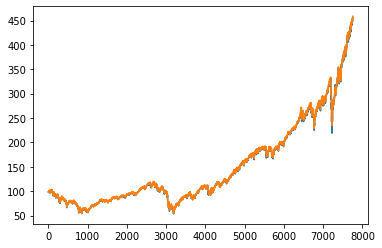

In [40]:
plt.plot(y)
plt.plot(yhat)
plt.show()

Demonstrate prediction

In [41]:
yhat = model.predict([X1_test,X2_test, X3_test, X4_test, X5_test])

In [42]:
print(f"Predicted: {yhat[0][0]:.2f}  Expected: {y_expected[0]:.2f}")

Predicted: 459.47  Expected: 446.19


**THIS IS NOT AN INVESTMENT ADVICE!**